# Анализ гипотез по увеличению выручки и результатов A/B теста.

Цель проекта - исследование гипотез по увеличению выручки интернет-магазина, приоритизация гипотез, анализ резултатов A/B теста, формирование выводов и предложений по результатам анализа. <br>
<br>
В рамках данного исследования планируется выполнить задачи:<br>
    1. Знакомство с данными. Общий обзор, предварительное знакомство с типами данных, наличием пропусков. Предобработка данных при необходимости.<br>
    2. Приоритизация гипотез для увеличения выручки.<br>
    3. Анализ результатов A/B теста:<br>
        - График кумулятивной выручки по группам.<br>
        - График кумулятивного среднего чека по группам.<br>
        - Анализ относительного изменения кумулятивного среднего чека группы B к группе A.<br>
        - График кумулятивного среднего количества заказов на посетителя по группам.  <br>
        - Анализ относительного изменения кумулятивного среднего количества заказов группы B к группе A.<br>
        - Оценка всплесков и выбросов в данных: построение точечных графиков и расчёт 95 и 99 перцентилей для выявления выбросов. .<br>
        - Расчёт статистической значимости различий в среднем количестве заказов и среднем чеке между группами.<br>
        - Расчёт статистической значимости различий в среднем количестве заказов и среднем чеке между группами по очищенным данным.<br>
    4. Выводы и рекомендации

## 1. Обзор данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    hypothesis = pd.read_csv('C:/Users/Azerty/Downloads/hypothesis.csv')
    orders = pd.read_csv('C:/Users/Azerty/Downloads/orders.csv')
    visitors = pd.read_csv('C:/Users/Azerty/Downloads/visitors.csv')
except:
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [5]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Данные полные, пропуски отсутствуют.

In [6]:
hypothesis.duplicated().sum()

0

In [7]:
orders.duplicated().sum()

0

In [8]:
visitors.duplicated().sum()

0

Дубликаты в данных отсутствуют.

Приведём названия столбцов к нижнему регистру.

In [9]:
hypothesis.columns = hypothesis.columns.str.lower()
#hypothesis.head()

Проверим, сколько групп принимало участие в тесте.

In [10]:
visitors['group'].unique()

array(['A', 'B'], dtype=object)

Всё в порядке, в тестировании принимали участие пользователи из 2 групп - как и должно быть.

Изучим временной интервал проведения теста.

In [11]:
print('Дата начала тестирования', visitors['date'].min())
print('Дата окончания тестирования', visitors['date'].max())

Дата начала тестирования 2019-08-01
Дата окончания тестирования 2019-08-31


Посмотрим, какое количество пользователей в каждой группе принимало участие в тестировании.

In [12]:
group_size = orders.pivot_table(index='group', values='visitorId', aggfunc='count')
group_size.columns = ['group_size']
group_size

,group_size
group,
A,557
B,640


Распределение пользователей по группам неравномерное. Это может повлиять на результаты тестирования. Следует уровнять группы.

**Вывод. Первоначальный обзор данных показал высокое качество подготовки данных - пропуски и дубликаты в данных всех трёх датасетов отсутствуют. Однако количество пользователей в группах тестирования распределено неравномерно. Группа B почти на 15% больше, что может оказать существенное влияние на результаты теста.**

## 2. Приоритизация гипотез.

Для запуска тестирования необходимо выбрать одну или несколько гипотез для работы. Для этого необходимо провести приоритизацию гипотез.

Сначала приоритизируем гипотезы с помощью фреймворка ICE.

In [13]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

In [14]:
hypothesis_ICE = hypothesis.sort_values('ICE', ascending=False)
pd.options.display.max_colwidth = 130
hypothesis_ICE


,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


Проведём приоритизацию гипотез с помощью фреймворка RICE.

In [15]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

In [16]:
pd.options.display.max_colwidth = 130
hypothesis.sort_values('RICE', ascending=False)


,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


После применения метода приоретизации RICE вместо ICE приоритет гипотез поменялся, так добавился ещё один множитель. Приоритизация по ICE предполагает оценку влияния на пользователей, уверенности в гипотезе и затрат на проверку гипотезы. Оценка по RICE помимо этого учитывает охват влияния изменений. Чем выше охват, тем выше приоритет гипотезы при прочих равных условиях. Чем больше охват влияния изменения, тем больше эффект этого изменения.

**Вывод. В первую очередь стоит проверить гипотезу о добавлении формы подписки на все основные страницы, она должна принести наибольшие результаты при относительно невысоких затратах на проверку гипотезы.**

## 3. Анализ результатов A/B теста.

Для анализа результатов тестирования и сравнения двух групп необходимо построить графики кумулятивных метрик.

Для построения графиков кумулятивных метрик необходимо подготовить кумулятивные данные.

In [17]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transactionId' : pd.Series.nunique,
'visitorId' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],\
                                                                         visitors['group'] == x['group'])].\
                                       agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).\
sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [18]:
print('Даты начала и окончания тестирования:', cumulativeData['date'].min(), 'и', cumulativeData['date'].max())

Даты начала и окончания тестирования: 2019-08-01 и 2019-08-31


Даты начала и окончания тестирования в кумулятивных данных совпадают с аналогичными датами в исходных данных.

Построим график кумулятивной выручки по группам.

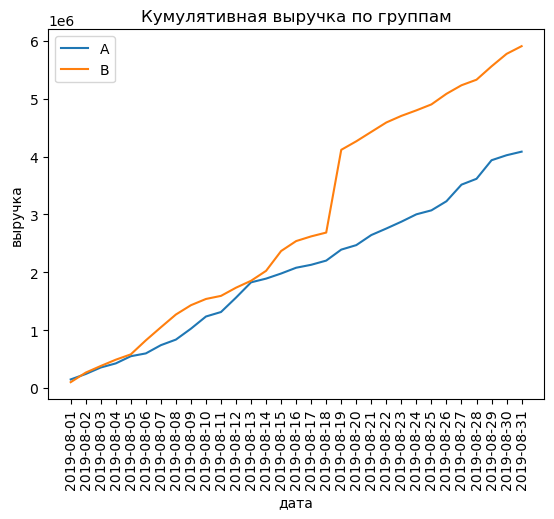

In [19]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
x_ticks = cumulativeRevenueA['date'].unique()
plt.xticks(ticks=x_ticks, rotation=90)
plt.title('Кумулятивная выручка по группам')
plt.xlabel('дата')
plt.ylabel('выручка')
plt.legend();

Выручка группы B стабильно выше на протяжении практически всего периода проведения тестирования. При этом виден ярко выраженный скачок в районе 19-20 августа. Поведение группы A более равномерное. Виден небольшой пологий холм повышения в районе 13 августа. Сложно объясниь скачок выручки, не имея дополнительных данных - например, о специализации интернет-магазина. Возможно, скачок связан с каким-то выбросом - аномальной покупкой.

Построим график кумулятивного среднего чека по группам.

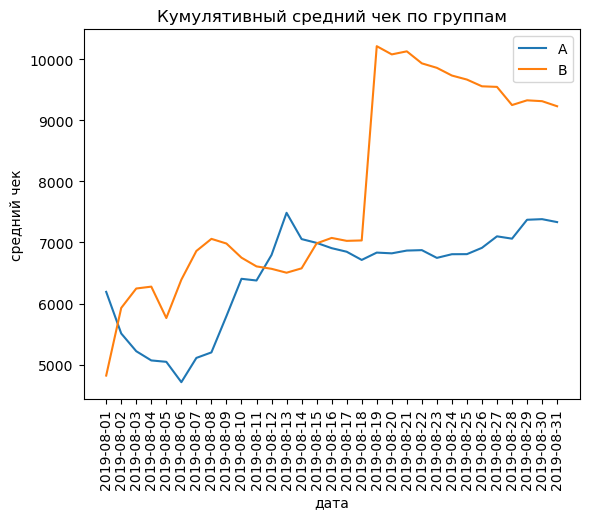

In [20]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
x_ticks = cumulativeRevenueA['date'].unique()
plt.xticks(ticks=x_ticks, rotation=90)
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('дата')
plt.ylabel('средний чек')
plt.legend();

Средний чек группы B выше, чем у группы A практически на протяжении всего периода тестирования, за исключением небольшого периода примерно в середине периода. В этот же момент кумулятивная выручка группы B сравнялась с выручкой группы A. Возможно, какое-то событие или сбой повлияло на изменение результатов в этот период. Также стоит отметить резкий скачок среднего чека группы B в то же время, что и резкий скачок кумулятивной выручки. Эти данные подтверждают предположение о какой-то аномально дорогой покупке.

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

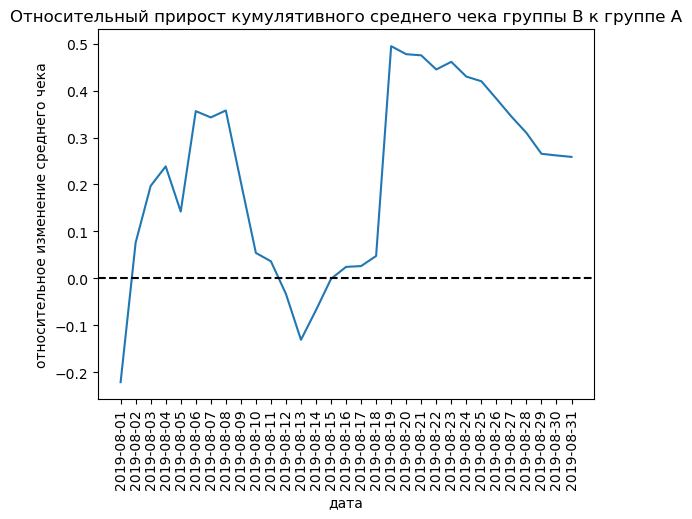

In [21]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(\
                                                   cumulativeRevenueB, left_on='date', right_on='date', how='left',\
                                                   suffixes=['A', 'B'])

plt.plot(mergedCumulativeRevenue['date'],\
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/\
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
x_ticks = mergedCumulativeRevenue['date'].unique()
plt.xticks(ticks=x_ticks, rotation=90)
plt.title('Относительный прирост кумулятивного среднего чека группы B к группе A')
plt.xlabel('дата')
plt.ylabel('относительное изменение среднего чека')
plt.axhline(y=0, color='black', linestyle='--');

Группа B на протяжении всего теста показывает поочередный относительный рост и падение среднего чека по сравнению с группой A. Большую часть времени тестирования средний чек группы B выше, чем у группы A. В период с 9 по 13 августа наблюдается снижение различия между средними чеками групп, однако 19-20 августа вновь виден резкий скачок - очередное подтверждение аномально дорогой покупки в группе B.

Построим график кумулятивного среднего количества заказов на посетителя по группам.

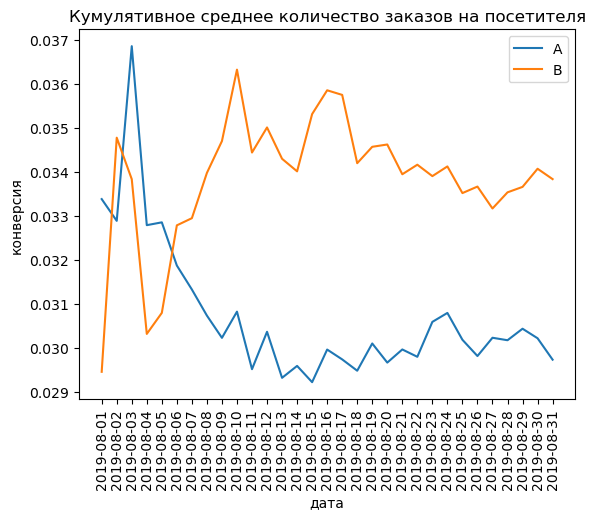

In [22]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
x_ticks = cumulativeDataA['date'].unique()
plt.xticks(ticks=x_ticks, rotation=90)
plt.title('Кумулятивное среднее количество заказов на посетителя')
plt.xlabel('дата')
plt.ylabel('конверсия')
plt.legend();

Практически на протяжении всего теста кумулятивная конверсия группы B выше, чем у группы A. В начале теста конверсия обеих групп сделала огромный резкий скачок, при этом показатели группы A были выше. Однако вскоре конверсия обеих групп стабилизировалась на выигрышной позиции группы B.

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

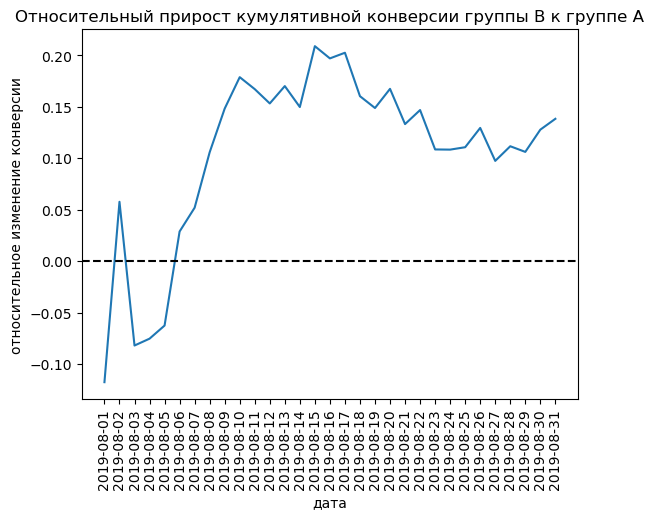

In [23]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].\
merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/\
         mergedCumulativeConversions['conversionA']-1)
x_ticks = mergedCumulativeConversions['date'].unique()
plt.xticks(ticks=x_ticks, rotation=90)
plt.title('Относительный прирост кумулятивной конверсии группы B к группе A')
plt.xlabel('дата')
plt.ylabel('относительное изменение конверсии')
plt.axhline(y=0, color='black', linestyle='--');

На протяжении большей части теста конверсия группы B показывает положительную динамику относительного изменения к группе A.

Для оценки наличия всплесков и выбросов в данных и исключения их влияния на результаты анализа построим точечные графики количества заказов и их стоимости и рассчитаем 95 и 99 перцентили по этим показателям.

Построим точечный график количества заказов по пользователям.

In [24]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']

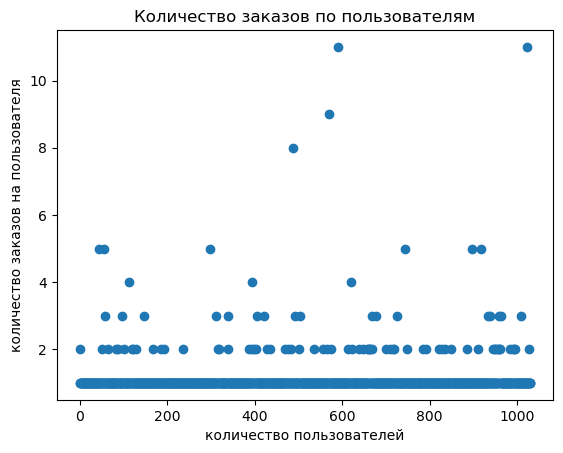

In [25]:
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Количество заказов по пользователям')
plt.xlabel('количество пользователей')
plt.ylabel('количество заказов на пользователя');

Основная масса пользователей совершила по одному заказу. Также достаточно большое количество пользователей совершили по 2 и 3  заказа.

Рассчитаем 95 и 99 перцентили количества заказов на пользователя.

In [26]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Не более 5% пользователей совершают более 2 заказов и не более 1% пользователей совершают более 4 заказов. Определим границу для определения аномальных пользователей при количестве заказов больше 3.

Построим точеченый график стоимости заказов.

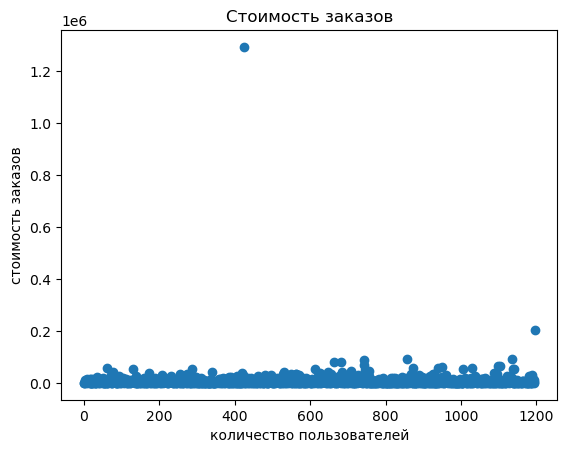

In [27]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Стоимость заказов')
plt.xlabel('количество пользователей')
plt.ylabel('стоимость заказов');

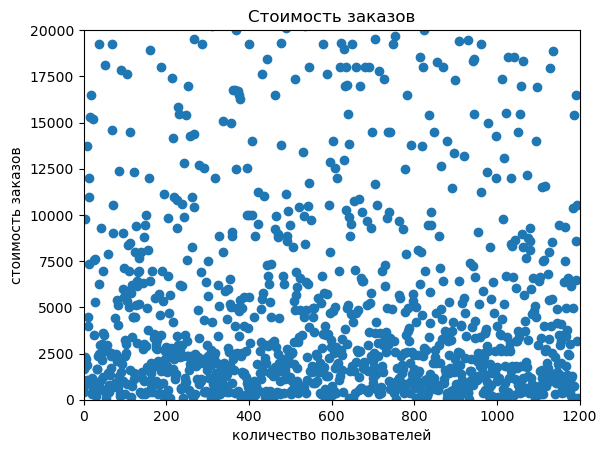

In [28]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Стоимость заказов')
plt.xlabel('количество пользователей')
plt.ylabel('стоимость заказов')
plt.axis([0, 1200, 0, 20000]);

Судя по графику основная часть заказов имеет стоимость до 10000. Однако имеются выбросы. Определим их.

Рассчитаем 95 и 99 перцентили стоимости заказов.

In [29]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Менее 5% пользователей совершают заказы стоимостью более 28000, менее 1% пользователей совершают заказы стоимостью более  58233. Определим границу аномальных пользователей со стоимостью заказов более 58233.

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя по группам.

Нулевая гипотеза - статистически значимых различий в конверсии по группам нет.<br>
Альтернативная гипотеза - различия в конверсии по группам есть.


In [30]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)
ordersByUsersA = (orders[orders['group'] == 'A'].groupby('visitorId', as_index=False).agg({'transactionId':pd.Series.nunique}))
ordersByUsersA.columns = ['visitorId', 'orders']
ordersByUsersB = (orders[orders['group'] == 'B'].groupby('visitorId', as_index=False).agg({'transactionId':pd.Series.nunique}))
ordersByUsersB.columns = ['visitorId', 'orders']
sampleA = pd.concat([ordersByUsersA['orders'], \
                     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),\
                               name = 'orders',),],axis=0,)
sampleB = pd.concat([ordersByUsersB['orders'], \
                     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),\
                               name = 'orders',),],axis=0,)

print('pvalue', '{0:.5f}'.format(st.mannwhitneyu(sampleA, sampleB) [1]))
print('относительное изменение группы B к группе A', '{0:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))

pvalue 0.01679
относительное изменение группы B к группе A 0.138


Значение pvalue меньше 0,05, значит нулевую гипотезу об отсутствии статистически значимых различий в среднем количестве заказов по группам отвергаем. Существуют статистически значимые различия между количеством заказов двух групп. Значение группы B на 13,8% лучше, чем у группы A.

Посчитаем статистическую значимость различий в среднем чеке заказов по группам.

Нулевая гипотеза - статистически значимых различий в среднем чеке по группам нет.<br>
Альтернативная гипотеза - различия в среднем чеке по группам есть.


In [31]:
print('pvalue', '{0:.3f}'.format(st.mannwhitneyu(orders[orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue'])[1]))
print('относительное изменение среднего чека группы B к группе A', '{0:.3f}'.format(orders[orders['group'] == 'B']['revenue'].mean() / orders[orders['group'] == 'A']['revenue'].mean() - 1))

pvalue 0.729
относительное изменение среднего чека группы B к группе A 0.259


Значение pvalue намного больше 0,05, значит нулевую гипотезу об отсутствии статистически значимых различий в среднем чеке заказов по группам не отвергаем. Статистически значимых различий между средними чеками групп нет. Хотя значение группы B на 25,9% лучше, чем у группы A. Можно предположить, что такие данные были получены случайно.

Подготовим очищенные данные без всплесков и аномалий.

In [32]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 3]['visitorId'],\
                                ordersByUsersB[ordersByUsersB['orders'] > 3]['visitorId'],], axis=0,)
usersWithExpensiveOrders = orders[orders['revenue'] > 58233]['visitorId']
abnormalUsers = (pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values())

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по очищенным данным.

Нулевая гипотеза - статистически значимых различий в конверсии по группам нет.<br>
Альтернативная гипотеза - различия в конверсии по группам есть.


In [33]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ), name='orders', ), ], axis=0, )
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ), name='orders', ), ], axis=0, )
print('pvalue', '{0:.5f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('относительное изменение конверсии группы B к группе A', '{0:.3f}'.format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

pvalue 0.01390
относительное изменение конверсии группы B к группе A 0.151


Значение pvalue меньше 0,05, значит нулевую гипотезу об отсутствии статистически значимых различий в среднем количестве заказов по группам отвергаем. Существуют статистически значимые различия между количеством заказов двух групп. Относительный прирост количества заказов на пользователя группы B составил 15,1%.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по очищенным данным.

Нулевая гипотеза - статистически значимых различий в среднем чеке по группам нет.<br>
Альтернативная гипотеза - различия в среднем чеке по группам есть.


In [34]:
print('pvalue', '{0:.3f}'.format(st.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'],
            orders[np.logical_and(orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'],)[1]))
print('относительное изменение группы B к группе A', '{0:.3f}'.format(orders[np.logical_and(orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'].mean()
        / orders[np.logical_and(orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'].mean() - 1))

pvalue 0.959
относительное изменение группы B к группе A -0.014


Значение pvalue намного больше 0,05, значит нулевую гипотезу об отсутствии статистически значимых различий в среднем чеке заказов по группам не отвергаем. Статистически значимых различий между средними чеками групп нет. Значение группы B на 1,4% хуже, чем у группы A.

**Вывод. По результатм A/B теста наблюдаются статистически значимые различия в конверсии между группами как на сырых, так и на очищенных данных.<br>
Значения относительного прироста конверсии группы B к группе A на сырых и очищенных данных достаточно близки и существенны: 13,8% и 15,1% соответственно. <br>
Статистически значимых различий по среднему чеку между группами нет ни на сырых, ни на очищенных данных. Однако результаты различаются: на сырых данных средний чек группы B существенно выше, однако после очистки, средний чек группы B даже немного хуже.**    

## 4. Выводы

**В ходе данного исследования были изучены и приоритизированы гипотезы отдела маркетинга по увеличению выручки. <br>
По результатам приоритизации была выбрана наиболее привлекательная гипотеза, по которой был проведён A/B тест. <br>
Анализ результатов теста показал наличие выбросов и аномалий в данных. <br>
Анализ сырых и очищенных данных показал наличие статистических различий в конверсии между группами с относительным приростом группы B к группе A в 15,1%.<br>
А вот статистических различий по среднему чеку между группами не обнаружено. И хотя относительные результаты отличаются на сырых и очищенных данных, проверка гипотезы не выявила различий в среднем чеке. <br>
Учитывая неравномерное распределение пользователей по группам, составляющее около 15%, сложно доверять результатм тестирования. Предлагается продолжить тест до выравнивания групп и после этого провести повторный анализ результатов.**